<a href="https://colab.research.google.com/github/yukliio/stemcamp.aistation/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement

# Step 1: importing the Dataset

In [3]:
!pip install kagglehub

Cloning into 'stemcamp.aistation'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 16), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 489.74 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/stemcamp.aistation


In [4]:
!mkdir -p ~/.kaggle
!cp /content/stemcamp.aistation/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify the credentials file is in place
!ls -al ~/.kaggle

# Download and unzip the Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -o chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [5]:
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
torch.manual_seed(42)

In [6]:
# load dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/train', transform=transform)
print(train_dataset.class_to_idx)
labels = list(train_dataset.class_to_idx.keys())

train_dataset[0][0].shape
len(train_dataset[0][0][0])

{'NORMAL': 0, 'PNEUMONIA': 1}


224

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


In [14]:
mean, std = get_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([-0.0002])
Std: tensor([1.0000])


In [9]:
normal_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/train', transform=normal_transform)
val_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/val', transform=normal_transform)
test_dataset_normal = datasets.ImageFolder(root='/content/stemcamp.aistation/chest_xray/chest_xray/test', transform=normal_transform)

train_loader = DataLoader(train_dataset_normal, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_normal, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_normal, batch_size=32, shuffle=True)

train_batch_features, train_batch_labels = next(iter(train_loader))
test_batch_features, test_batch_labels  = next(iter(test_loader))
val_batch_features, val_batch_labels  = next(iter(val_loader))

print(len(train_dataset_normal))



5216


In [10]:
# test the normalization
images, _ = next(iter(train_loader))
print("Batch mean:", images.mean().item())
print("Batch std:", images.std().item())

Batch mean: -0.06112612038850784
Batch std: 0.9658132791519165


# Viualizing our data

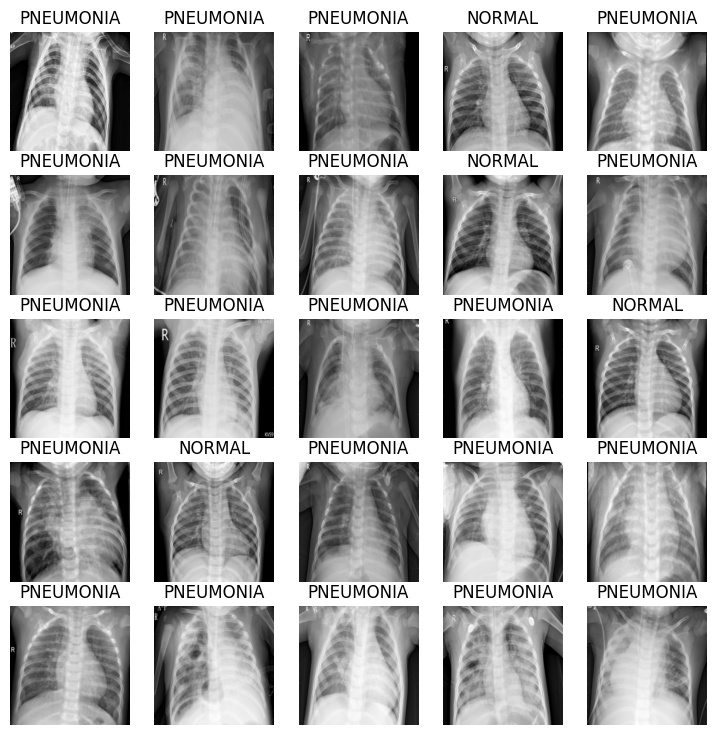

In [36]:


import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 5, 5

for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(train_dataset_normal), size=[1]).item()
    image, label = train_dataset_normal[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(labels[label])
    plt.axis("off")



# Building the model

In [32]:
import torch.nn as nn

class PnemoniaModelV1(nn.Module):
    """
    Model architecture that replicates the TinyVGG architecture.
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 56 * 56,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        print(f"shape after conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        print(f"shape after conv block 2: {x.shape}")
        x = self.classifier(x)
        print(f"shape after classifier: {x.shape}")
        return x




Text(0.5, 1.0, 'NORMAL')

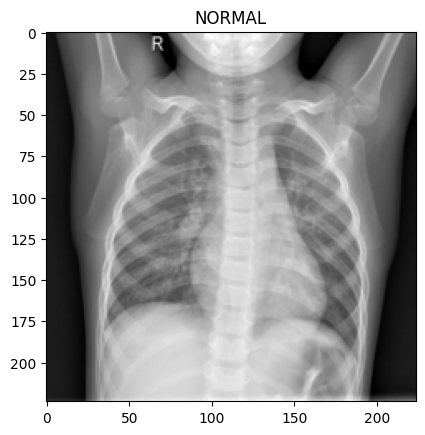

In [42]:
image, label = train_dataset_normal[0]
plt.imshow(torch.squeeze(image), cmap='grey')
plt.title(labels[label])

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
torch.manual_seed(42)
model_1 = PnemoniaModelV1(
    input_shape=1,
    hidden_units=10,
    output_shape=len(labels))

In [35]:
rand_image_tensor = torch.randn(size=(1,224,224))
model_1(rand_image_tensor.unsqueeze(0))

shape after conv block 1: torch.Size([1, 10, 112, 112])
shape after conv block 2: torch.Size([1, 10, 56, 56])
shape after classifier: torch.Size([1, 2])


tensor([[-0.0376,  0.1286]], grad_fn=<AddmmBackward0>)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# meaure time
from timeit import default_timer as timer

train_time_start_model1 = timer()

#train and test model
epochs = 3
for epoch in tqdm(range(epochs)):